In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import model
import datetime as dt
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
data = pd.read_csv("/media/disk2/gdrozdov/GAZP_171201_190301_5min.csv")
data.columns = data.columns.str.replace("<|>", "")
data = data.drop('TIME', 1)
data_real = data
full_size = data_real.shape[0]
train_size = 29808
data = data[:train_size]
#period 5 minutes - 105 points per day 29807 points to 17/01/19 remainig points to 01/03/19 for plot
date_ori = pd.to_datetime(data.iloc[:, 0]).tolist()
data.shape

(29808, 6)

In [2]:
#map data - to number of day
dayNumber = dict()
k = 0
for i in range(full_size - 1):
    k += 1
    cur = data_real.iloc[i : i + 1, 0].values[0]
    nextV = data_real.iloc[i + 1 : i + 2, 0].values[0]
    if (cur != nextV or i == full_size - 2):
        dayNumber[k] = cur

In [3]:
minmax = MinMaxScaler().fit(data.iloc[:, 1:].astype('float64'))# minus min then divide all (max-min)
df_log = minmax.transform(data.iloc[:, 1:].astype('float64'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4
0,0.074917,0.075381,0.079588,0.072891,0.015388
1,0.072621,0.078513,0.085155,0.079365,0.019745
2,0.079299,0.082689,0.088866,0.075606,0.037478
3,0.076169,0.073711,0.083711,0.072055,0.016181
4,0.071578,0.073502,0.083711,0.077277,0.006163


In [4]:
num_layers = 1
size_layer = 128
timestamp = 105 * 10
epoch = 100
dropout_rate = 0.7
future_day = full_size - data.shape[0] + 1

In [5]:
tf.reset_default_graph()
modelnn = model.Model(0.01, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss_mse = 0
    total_loss_mae = 0
    total_r2 = 0
    for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
        batch_x = np.expand_dims(df_log.iloc[k: k + timestamp, :].values, axis = 0)#expand_dims - вставляем в массив(axis = 0) по горизонтали
        batch_y = df_log.iloc[k + 1: k + timestamp + 1, :].values
        last_state, _, loss_mse, loss_mae, r2 = sess.run([modelnn.last_state, 
                                        modelnn.optimizer, 
                                        modelnn.cost, modelnn.mae, modelnn.r2], feed_dict={modelnn.X: batch_x, 
                                                                  modelnn.Y: batch_y, 
                                                                  modelnn.hidden_layer: init_value})#в feed_dict данные для функции y (sess.run(y, feed_dict={}))
        
        loss_mse = np.mean(loss_mse)
        loss_mae = np.mean(loss_mae)
        r2 = np.mean(r2)
        init_value = last_state
        total_loss_mse += loss_mse
        total_loss_mae += loss_mae
        total_r2 += r2
    total_loss_mse /= (df_log.shape[0] // timestamp)
    total_loss_mae /= (df_log.shape[0] // timestamp)
    total_r2 /= (df_log.shape[0] // timestamp)
    if (i + 1) % 10 == 0:
        print('epoch:', i + 1, 'avg loss mse: ', total_loss_mse, 'avg loss mae: ', total_loss_mae, 'avg r2: ', r2)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
epoch: 10 avg loss mse:  0.054091389424 avg loss mae:  0.181867717632 avg r2:  0.189781
epoch: 20 avg loss mse:  0.0195843838821 avg loss 

In [6]:
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0, :] = df_log.iloc[0, :]
upper_b = (df_log.shape[0] // timestamp) * timestamp #для оставшейся части данных(в случае если // timestamp не нацело)
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run([modelnn.logits, modelnn.last_state], feed_dict = {modelnn.X:np.expand_dims(df_log.iloc[k: k + timestamp, :], axis = 0),
                                     modelnn.hidden_layer: init_value})
    init_value = last_state
    output_predict[k + 1: k + timestamp + 1, :] = out_logits
    
out_logits, last_state = sess.run([modelnn.logits, modelnn.last_state], feed_dict = {modelnn.X:np.expand_dims(df_log.iloc[upper_b: , :], axis = 0),
                                     modelnn.hidden_layer: init_value})
init_value = last_state
output_predict[upper_b + 1: df_log.shape[0] + 1, :] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1, :]
date_ori.append(date_ori[-1] + timedelta(days=1))

In [7]:
for i in range(future_day - 1):
    out_logits, last_state = sess.run([modelnn.logits, modelnn.last_state], feed_dict = {modelnn.X:np.expand_dims(df_log.iloc[-timestamp:, :], axis = 0),
                                     modelnn.hidden_layer: init_value})
    init_value = last_state
    output_predict[df_log.shape[0], :] = out_logits[-1, :]
    df_log.loc[df_log.shape[0]] = out_logits[-1, :]
    date_ori.append(date_ori[-1] + timedelta(days=1))

In [8]:
df_log = minmax.inverse_transform(output_predict)
date_ori=pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()

In [9]:
df_log_by_days_close = np.array([])
for i in range(len(df_log)):
    if (i + 1 in dayNumber):
        df_log_by_days_close = np.append(df_log_by_days_close, df_log[i][3])

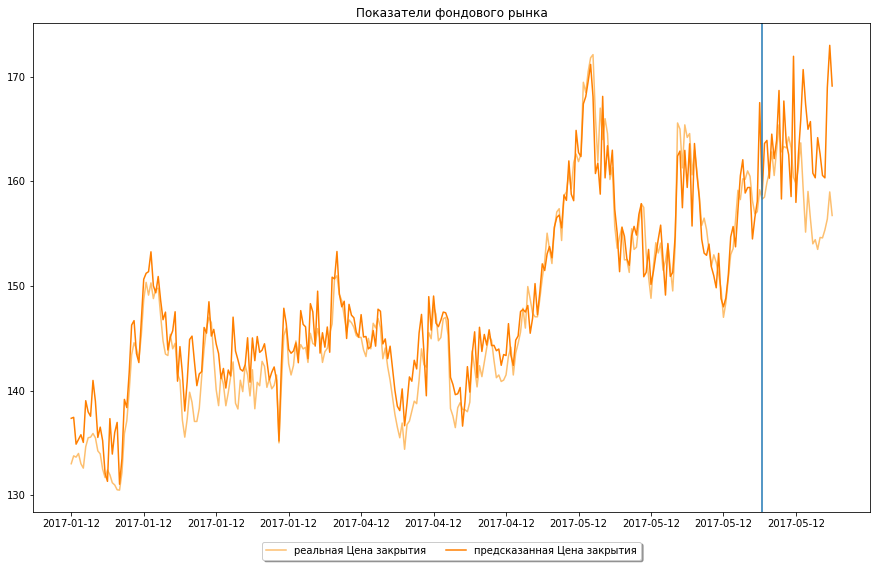

In [10]:
current_palette = sns.color_palette("Paired", 12)
fig = plt.figure(figsize = (15,10))
ax = plt.subplot(111)
x_range_original = np.arange(len(dayNumber))
x_range_future = np.arange(len(dayNumber))
ax.plot(x_range_original, data_real.loc[[i for j, i in enumerate(data_real.index) if (j + 1 in dayNumber)]]['CLOSE'], label = 'реальная Цена закрытия', color = current_palette[6])
ax.plot(x_range_future, df_log_by_days_close, label = 'предсказанная Цена закрытия', color = current_palette[7])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc = 'upper center', bbox_to_anchor= (0.5, -0.05), fancybox = True, shadow = True, ncol = 4)
plt.axvline(x=286)#граница откуда идёт предсказание
plt.title('Показатели фондового рынка')
plt.xticks(x_range_future[::30], date_ori[::30])#через каждые 30 дней ставим метку снизу
plt.show()

In [9]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

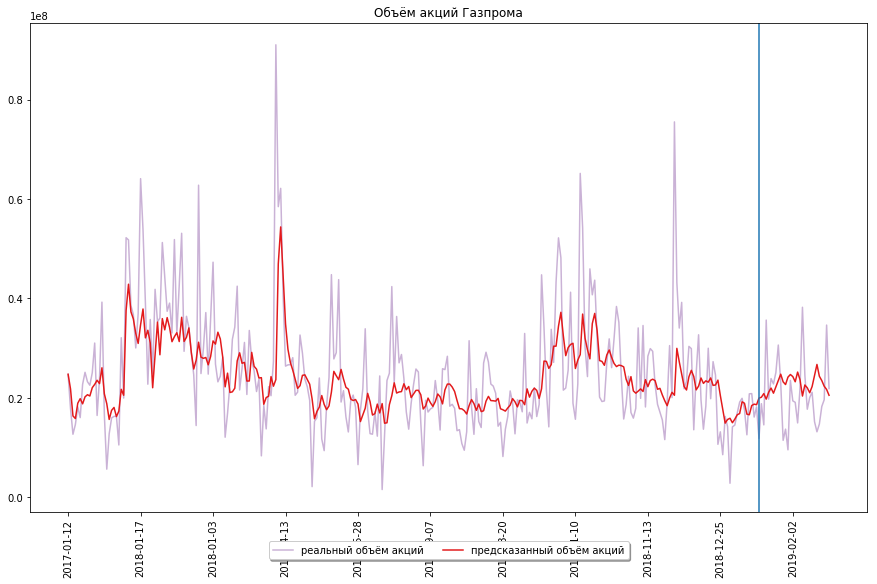

In [10]:
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
ax.plot(x_range_original, data_real.iloc[:, -1], label = 'реальный объём акций',color = current_palette[8])
ax.plot(x_range_future, anchor(df_log[:, -1], 0.5), label = 'предсказанный объём акций', color = current_palette[5])
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.axvline(x=286)#граница откуда идёт предсказание
plt.xticks(x_range_future[::30], date_ori[::30], rotation ='vertical')
plt.title('Объём акций Газпрома')
plt.show()

In [11]:
real_close = data_real['CLOSE'].values[full_size - future_day:]
predicted_close = df_log[:, 3][full_size - future_day:]
r2 = r2_score(real_close, predicted_close)
mse = mean_squared_error(real_close, predicted_close)
mae = mean_absolute_error(real_close, predicted_close)
print('r2_score =', round(r2, 4), 'mse =', round(mse, 4), 'mae =', round(mae, 4))

r2_score = 0.1846 mse = 9.852 mae = 2.5863
